In [ ]:

from time import sleep
import requests
from google.colab import files
import pandas as pd
from bs4 import BeautifulSoup # pour extraire des données à partir de fichiers HTML et XML

def soup2list(src, list_, attr=None):
    if attr:
        for val in src:
            list_.append(val[attr])
    else:
        for val in src:
            list_.append(val.get_text())

users = []
userReviewNum = []
ratings = []
locations = []
dates = []
reviews = []

from_page = 1
to_page = 35
company = 'fedex.com'

for i in range(from_page, to_page+1):

   result = requests.get(fr"https://www.trustpilot.com/review/{company}?page={i}")
   soup = BeautifulSoup(result.content)

   # Trust Pilot was setup in a way that's not friendly to scraping, so this hacky method will do.
   soup2list(soup.find_all('span', {'class','typography_heading-xxs__QKBS8 typography_appearance-default__AAY17'}), users)
   soup2list(soup.find_all('div', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua'}), locations)
   soup2list(soup.find_all('span', {'class','typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l'}), userReviewNum)
   soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), dates)
   soup2list(soup.find_all('div', {'class','styles_reviewHeader__iU9Px'}), ratings, attr='data-service-review-rating')
   soup2list(soup.find_all('div', {'class','styles_reviewContent__0Q2Tg'}), reviews)

   # To avoid throttling
   sleep(1) # une pause d'une seconde entre chaque requête pour éviter d'être bloqué par le site web

review_data = pd.DataFrame(
{
   'Username':users,
   'Total reviews':userReviewNum,
   'location':locations,
   'date':dates,
   'content':reviews,
   'Rating': ratings
})


In [ ]:
review_data

,Username,Total reviews,location,date,content,Rating
0,Coral Hartford,1 review,US,20 hours ago,If I could rate FedEx zero stars I…If I could ...,1
1,Francesca Nobili,3 reviews,US,20 hours ago,Drivers NEVER follow delivery instructions…I h...,2
2,Mat Neumann Mat,1 review,DE,4 days ago,"0 stars as always Guys, as always 0 stars. Tra...",1
3,Mimi,8 reviews,US,2 days ago,No delivery 17 days and waiting for a package ...,1
4,Prof. Dr. Jariya,1 review,FR,A day ago,Pathetic serviceMy shipment from China arrived...,1
...,...,...,...,...,...,...
695,Umme Rima,2 reviews,CA,"Dec 6, 2023","My package is lostMy package is lost, it shows...",1
696,Virginia,5 reviews,US,"Dec 6, 2023",Received an email from FedEx saying package is...,1
697,Elizabeth Gels,1 review,US,"Dec 6, 2023",FedEx is consistently awfulFedEx is consistent...,1
698,Jeff Donecker,1 review,US,"Dec 6, 2023","Incorrect addressIncorrect address, contackes ...",1


In [ ]:
print(review_data.shape)

(700, 6)


# Data Cleaning


Je vais d'abord importer toutes les API et les programmes nécessaires Cela inclut le prétraitement des données, la catégorisation des avis en sentiments et polarités, la création de nuages de mots, ainsi que la création de visualisations pour les données.

In [ ]:
# import necessary apis and others
from textblob import TextBlob #textblob
import pandas as pd # data processing
import plotly.express as px # plotly library
import numpy as np # linear algebra
from wordcloud import WordCloud # import wordcloud
import matplotlib.pyplot as plt #import matplotlib

In [ ]:
# Load file into a pandas dataframe and read dataset
df = pd.read_csv("/content/reviews (2).csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Username       700 non-null    object
 1   Total reviews  700 non-null    object
 2   location       700 non-null    object
 3   date           700 non-null    object
 4   content        700 non-null    object
 5   Rating         700 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 32.9+ KB


Je vais d'abord effectuer le prétraitement avant de commencer l'extraction des syntagmes nominaux. Le prétraitement consiste à diviser le texte en termes plus simples (tokenisation) et à normaliser le texte. J'utilise également NLTK (stopwords et word_tokenize) pour normaliser le texte et le préparer pour l'analyse. Cette étape est importante car elle permet un processus d'analyse plus précis. Les stopwords suppriment les mots courants qui ne portent pas beaucoup de sentiments, et word_tokenize divise le texte en mots individuels.

In [ ]:
!pip install nltk

In [ ]:
import nltk # pour normaliser le texte en le tokenisant en supprimant les ponctuations, les stopwords ,..
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(df):
    # Convertir le texte en minuscules et supprimer la ponctuation
    df['Preprocessed_content'] = df['content'].str.lower()
    df['Preprocessed_content'] = df['Preprocessed_content'].str.replace('[{}]'.format(string.punctuation), '')

    # Supprimer les valeurs manquantes
    df['Preprocessed_content'].fillna('', inplace=True)

    # Tokenisation pour diviser le texte en mots individuels
    df['Tokenized_content'] = df['Preprocessed_content'].apply(word_tokenize)

    # Supprimer les mots vides en utilisant une liste prédéfinie de stopwords
    stop_words = set(stopwords.words('english'))
    df['Filtered_content'] = df['Tokenized_content'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # Convertir le contenu filtré en texte
    df['Filtered_content'] = df['Filtered_content'].apply(' '.join)

    # Supprimer les colonnes prétraitées et non nécessaires
    df.drop(['Preprocessed_content', 'Tokenized_content', 'word_count'], axis=1, inplace=True)

# Appeler la fonction pour appliquer le prétraitement
preprocess_text(df)

# Afficher la DataFrame avec la colonne 'Filtered_content'
df




,Username,Total reviews,location,date,content,Rating,Filtered_content
0,Mat Neumann Mat,1 review,DE,17 hours ago,"0 stars as always Guys, as always 0 stars. Tra...",1,"0 stars always guys , always 0 stars . trackin..."
1,PARADOXIAN,3 reviews,US,11 hours ago,No client care team what so ever..No client ca...,1,client care team ever .. client care team ever...
2,Anabel Navarrete,1 review,US,19 hours ago,Missing Boxes & Rude services from Mss. HOPE (...,1,missing boxes & rude services mss . hope ( man...
3,EAdH,5 reviews,US,12 hours ago,Expensive packages dumped in driveway.We staye...,1,expensive packages dumped driveway.we stayed h...
4,David Doughty,1 review,GB,2 days ago,Fed Ex should be avoided at all costsFed Ex sh...,1,fed ex avoided costsfed ex avoided costs . sup...
...,...,...,...,...,...,...,...
695,Richard Drury,10 reviews,GB,"Dec 5, 2023",Avoid FedExOrdered coffee pods from Nespresso ...,1,avoid fedexordered coffee pods nespresso canad...
696,Babajide Owoeye,1 review,GB,"Dec 5, 2023",FedEx change the tracking number on my…FedEx c...,1,fedex change tracking number my…fedex change t...
697,Lars Hektoen,6 reviews,NO,"Dec 5, 2023",I paid for my shipment and have proof…I paid f...,2,paid shipment proof…i paid shipment proof . st...
698,Juan Bautista,2 reviews,US,"Dec 5, 2023",Fed ex suxsThey didn't send me an email saying...,1,fed ex suxsthey n't send email saying package ...


Features Engineering

# Calculate the polarity of the review

Pour calculer la polarité de chaque critique, je vais d'abord créer une fonction utilisant des tutoriels de TextBlob . Ensuite, je vais vérifier si la critique est une chaîne de caractères car certaines critiques peuvent être manquantes dans le jeu de données. Si la critique n'est pas manquante, je vais lui attribuer une polarité par défaut (neutre) de 0.0. Ensuite, je vais appliquer le calcul de polarité en l'assignant à la colonne 'content' qui contient les critiques textuelles.

In [ ]:
from textblob import TextBlob # offre une API simple pour effectuer diverses tâches de traitement du langage naturel ( calcul de polarité)

# Define function to calculate polarity of review
def calculate_polarity(review):
    if isinstance(review, str):  # Check if review is a string
        textblob = TextBlob(review)
        polarity = textblob.sentiment.polarity
    else:
        polarity = 0.0  # Assign a default polarity for missing or non-string values
    return polarity

# Apply polarity calculation function to dataset and store results in new column
df['Polarity'] = df['Filtered_content'].apply(calculate_polarity)

In [ ]:
# Print the results: Review text and Polarity
print(df[['Filtered_content', 'Polarity']])

                                      Filtered_content  Polarity
0    0 stars always guys always 0 stars tracking st...  0.000000
1    client care team everno client care team ever ... -0.166667
2    missing boxes rude services mss hope manager c... -0.211111
3    expensive packages dumped drivewaywe stayed ho... -0.087143
4    fed ex avoided costsfed ex avoided costs suppo...  0.093750
..                                                 ...       ...
695  avoid fedexordered coffee pods nespresso canad... -0.041667
696  fedex change tracking number my…fedex change t... -0.208333
697  paid shipment proof…i paid shipment proof stil...  0.068182
698  fed ex suxsthey didnt send email saying packag...  0.000000
699  hall shame driver manageri receiving expensive... -0.105208

[700 rows x 2 columns]


# Classify sentiments into labels (positive, negative, neutral)

In [ ]:
# Define function to classify sentiment of review
def classify_sentiment(review):
    if isinstance(review, str):  # Check if review is a string
        textblob = TextBlob(review)  # Create TextBlob object from review text
        sentiment = textblob.sentiment.polarity  # Calculate sentiment polarity
        if sentiment > 0:
            return 'Positive'
        elif sentiment < 0:
            return 'Negative'
        else:
            return 'Neutral'
    else:
        return 'Neutral'  # Return 'Neutral' for missing or non-string values

# Apply sentiment classification function dataset and store results in new column
df['Sentiment'] = df['Filtered_content'].apply(classify_sentiment)

In [ ]:
# Print results for reviews and sentiments
print(df[['Filtered_content', 'Sentiment']])

                                      Filtered_content Sentiment
0    0 stars always guys always 0 stars tracking st...   Neutral
1    client care team everno client care team ever ...  Negative
2    missing boxes rude services mss hope manager c...  Negative
3    expensive packages dumped drivewaywe stayed ho...  Negative
4    fed ex avoided costsfed ex avoided costs suppo...  Positive
..                                                 ...       ...
695  avoid fedexordered coffee pods nespresso canad...  Negative
696  fedex change tracking number my…fedex change t...  Negative
697  paid shipment proof…i paid shipment proof stil...  Positive
698  fed ex suxsthey didnt send email saying packag...   Neutral
699  hall shame driver manageri receiving expensive...  Negative

[700 rows x 2 columns]


In [ ]:

# Déterminer le nombre de lignes supplémentaires nécessaires pour atteindre 1000
additional_rows_needed = 1000 - len(df)

# Sélectionner aléatoirement des lignes supplémentaires du DataFrame existant
additional_rows = df.sample(n=additional_rows_needed, replace=True)

# Concaténer le DataFrame initial avec les lignes supplémentaires
df_augmented = pd.concat([df, additional_rows])

# Afficher les résultats
print(df_augmented[['Filtered_content', 'Sentiment']])


                                      Filtered_content Sentiment
0    0 stars always guys always 0 stars tracking st...   Neutral
1    client care team everno client care team ever ...  Negative
2    missing boxes rude services mss hope manager c...  Negative
3    expensive packages dumped drivewaywe stayed ho...  Negative
4    fed ex avoided costsfed ex avoided costs suppo...  Positive
..                                                 ...       ...
643  fedex sucksfedex sucks use reason try talk cus...  Positive
124  worst customer service ever…the worst customer...  Negative
209  fedex jokefedex joke monitor dell 2 day guaran...  Negative
462  unsustainable want run businessves• drivers co...  Positive
525  worst company farthe worst company far never r...  Negative

[1000 rows x 2 columns]


In [ ]:
# Supposons que df soit votre dataframe
selection = df_augmented[['Filtered_content', 'Sentiment']]

# Écrivez la sélection dans un fichier CSV
selection.to_csv('selection.csv', index=False)

# Téléchargez le fichier localement
from google.colab import files
files.download('selection.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.columns

Index(['Username', 'Total reviews', 'location', 'date', 'content', 'Rating',
       'Preprocessed_content', 'Tokenized_content', 'Filtered_content',
       'Polarity', 'Sentiment'],
      dtype='object')

In [ ]:
df

,Username,Total reviews,location,date,content,Rating,Preprocessed_content,Tokenized_content,Filtered_content,Polarity,Sentiment
0,Mat Neumann Mat,1 review,DE,17 hours ago,"0 stars as always Guys, as always 0 stars. Tra...",1,0 stars as always guys as always 0 stars track...,"[0, stars, as, always, guys, as, always, 0, st...",0 stars always guys always 0 stars tracking st...,0.000000,Neutral
1,PARADOXIAN,3 reviews,US,11 hours ago,No client care team what so ever..No client ca...,1,no client care team what so everno client care...,"[no, client, care, team, what, so, everno, cli...",client care team everno client care team ever ...,-0.166667,Negative
2,Anabel Navarrete,1 review,US,19 hours ago,Missing Boxes & Rude services from Mss. HOPE (...,1,missing boxes rude services from mss hope man...,"[missing, boxes, rude, services, from, mss, ho...",missing boxes rude services mss hope manager c...,-0.211111,Negative
3,EAdH,5 reviews,US,12 hours ago,Expensive packages dumped in driveway.We staye...,1,expensive packages dumped in drivewaywe stayed...,"[expensive, packages, dumped, in, drivewaywe, ...",expensive packages dumped drivewaywe stayed ho...,-0.087143,Negative
4,David Doughty,1 review,GB,2 days ago,Fed Ex should be avoided at all costsFed Ex sh...,1,fed ex should be avoided at all costsfed ex sh...,"[fed, ex, should, be, avoided, at, all, costsf...",fed ex avoided costsfed ex avoided costs suppo...,0.093750,Positive
...,...,...,...,...,...,...,...,...,...,...,...
695,Richard Drury,10 reviews,GB,"Dec 5, 2023",Avoid FedExOrdered coffee pods from Nespresso ...,1,avoid fedexordered coffee pods from nespresso ...,"[avoid, fedexordered, coffee, pods, from, nesp...",avoid fedexordered coffee pods nespresso canad...,-0.041667,Negative
696,Babajide Owoeye,1 review,GB,"Dec 5, 2023",FedEx change the tracking number on my…FedEx c...,1,fedex change the tracking number on my…fedex c...,"[fedex, change, the, tracking, number, on, my…...",fedex change tracking number my…fedex change t...,-0.208333,Negative
697,Lars Hektoen,6 reviews,NO,"Dec 5, 2023",I paid for my shipment and have proof…I paid f...,2,i paid for my shipment and have proof…i paid f...,"[i, paid, for, my, shipment, and, have, proof…...",paid shipment proof…i paid shipment proof stil...,0.068182,Positive
698,Juan Bautista,2 reviews,US,"Dec 5, 2023",Fed ex suxsThey didn't send me an email saying...,1,fed ex suxsthey didnt send me an email saying ...,"[fed, ex, suxsthey, didnt, send, me, an, email...",fed ex suxsthey didnt send email saying packag...,0.000000,Neutral


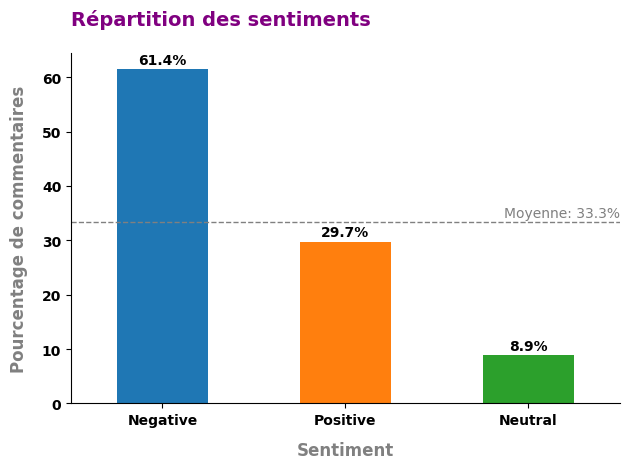

In [ ]:
import matplotlib.pyplot as plt

# Compter les occurrences de chaque sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Calculer les pourcentages
total = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total) * 100

# Couleurs plus vibrantes pour les barres
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Créer un plot à barres pour visualiser les sentiments avec pourcentages
ax = sentiment_percentages.plot(kind='bar', color=colors)

# Ajouter les pourcentages au-dessus de chaque barre avec un style différent
for i, percentage in enumerate(sentiment_percentages):
    ax.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', color='black', fontweight='bold')

# Ajouter des bordures aux barres pour plus de distinction
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajouter une ligne horizontale pour représenter la moyenne
mean_percentage = sentiment_percentages.mean()
ax.axhline(y=mean_percentage, color='grey', linestyle='--', linewidth=1)
plt.text(len(sentiment_percentages) - 0.5, mean_percentage + 1, f'Moyenne: {mean_percentage:.1f}%', ha='right', color='grey')

# Ajouter un titre et des étiquettes aux axes
plt.title('Répartition des sentiments', fontsize=14, fontweight='bold', color='purple', loc='left', pad=20)
plt.xlabel('Sentiment', fontsize=12, fontweight='bold', color='gray', labelpad=10)
plt.ylabel('Pourcentage de commentaires', fontsize=12, fontweight='bold', color='gray', labelpad=10)

# Personnaliser les ticks et les labels
plt.xticks(rotation=0, fontsize=10, fontweight='bold', color='black')
plt.yticks(fontsize=10, fontweight='bold', color='black')

# Ajuster la mise en page pour éviter que les annotations ne soient tronquées
plt.tight_layout()

# Afficher le plot
plt.show()


# Findings

1. Visualization of Polarity of Reviews by Country

In [ ]:
# Sort the dataframe by location
df.sort_values('location', inplace=True)

# Create scatter plot with Plotly
fig = px.scatter(df, x='Polarity', y='location')

# Customize plot
fig.update_layout(
    title='Polarity vs. Country of FEDEX Reviews',
    xaxis_title='Polarity',
    yaxis_title='location',
    yaxis=dict(
        ticktext=df['location'].unique(),
        tickvals=df['location'].unique(),
        dtick=10  # Increase spacing between words
    )
)

# Show plot
fig.show()


2. Visualization of Sentiments by Country

In [ ]:
# Count the number of sentiments per category and location
sentiment_counts = df.groupby(['location', 'Sentiment']).size().reset_index(name='Count')

# Create a stacked bar graph with Plotly
fig = px.bar(sentiment_counts, x='location', y='Count', color='Sentiment', barmode='stack',
             category_orders={'Sentiment': ['Positive', 'Neutral', 'Negative']},
             opacity=0.8  # Bar opacity
             )

# Customize the plot
fig.update_layout(
    title='Sentiment Distribution by Country of FEDEX Reviews',
    xaxis_title='location',
    yaxis_title='Number of Sentiments',
    showlegend=True,  # Show the legend for individual bars
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
)

# Show the plot
fig.show()

3. Wordcloud for Positive Sentiment

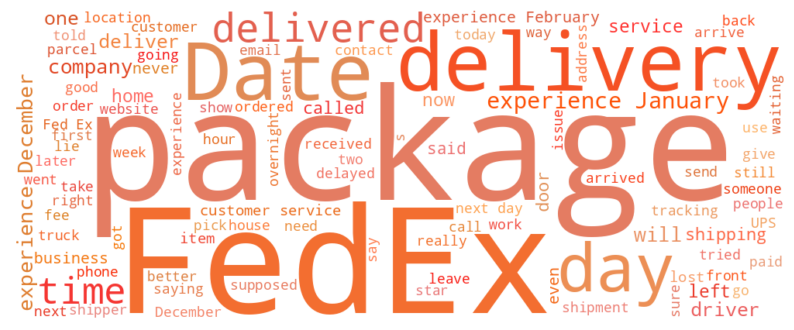

In [ ]:
import random # for random colors

# Filter DataFrame to include only Positive reviews
Positive_reviews = df[df['Sentiment'] == 'Positive']

# Make all negative reviews into one string
reviews_text = ' '.join(negative_reviews['content'])

# Make warm positive tones for each word
def warm_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({random.randint(0, 30)}, {random.randint(70, 100)}%, {random.randint(50, 70)}%)"

# Create WordCloud object and generate the word cloud
wordcloud = WordCloud(width=1000, height=400, max_words=100, background_color='white', color_func=warm_color).generate(reviews_text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Pour ce nuage de mots des avis positifs, certains mots à remarquer sont Date, time, delivery,customer, experience,First , ordred et package.

3. Wordcloud for Negative Sentiment

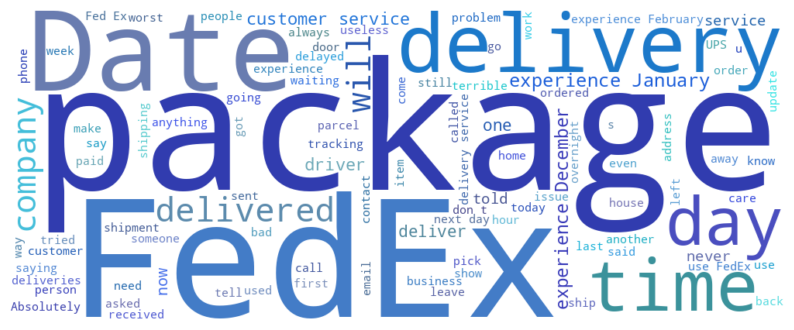

In [ ]:
# Filter DataFrame to include only negative reviews
negative_reviews = df[df['Sentiment'] == 'Negative']

# Make all negative reviews one single string
reviews_text = ' '.join(negative_reviews['content'])

# Make blue, cool tones for each word
def cool_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl({random.randint(180, 240)}, {random.randint(30, 80)}%, {random.randint(40, 60)}%)"

# Create WordCloud object and generate the word cloud
wordcloud = WordCloud(width=1000, height=400, max_words=100, background_color='white', color_func=cool_color).generate(reviews_text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Pour ce nuage de mots des sentiments négatifs, il y a des mots notables comme Waiting, worst, bad, problem et customer service. Cela pourrait éventuellement se référer à des avis sur les commandes en retard/annulées et un mauvais service client.